In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PhysicsData import A, b, x0;

EE (50, 400)
TT (50, 400)
ATTENTION: You picked scalar particle make sure that
ATTENTION: omega integration bounds are set to [0, inf)
ATTENTION: kernel mltiplied by w**2
(50,)


/Users/nick/Desktop/Summer 2024/KL Problem/PhysicsData.py:28: RuntimeWarning: divide by zero encountered in divide
  GG_rho = g2_rhopipi / (48*np.pi) * mass_rho * ( 1 - 4*mass_pi**2 / omegas**2 )**(3/2) * np.heaviside(omegas - 2*mass_pi , 0.5)
/Users/nick/Desktop/Summer 2024/KL Problem/PhysicsData.py:28: RuntimeWarning: invalid value encountered in power
  GG_rho = g2_rhopipi / (48*np.pi) * mass_rho * ( 1 - 4*mass_pi**2 / omegas**2 )**(3/2) * np.heaviside(omegas - 2*mass_pi , 0.5)
/Users/nick/Desktop/Summer 2024/KL Problem/PhysicsData.py:28: RuntimeWarning: invalid value encountered in multiply
  GG_rho = g2_rhopipi / (48*np.pi) * mass_rho * ( 1 - 4*mass_pi**2 / omegas**2 )**(3/2) * np.heaviside(omegas - 2*mass_pi , 0.5)


Auxilliary functions:

In [3]:
def KL(x, mu): 
  # assume mu is postive 
  if np.sum(x) > 1.01 or np.sum(x) < 0.99 or np.any(x<0) == True:
    return np.inf
  x_ = x[x>0]
  mu_ = mu[x>0]
  return np.dot(x_, np.log(x_ / mu_))


def set_x(A, mu, y): 
  a = A.T @ y
  M = np.max(a) # to prevent overflow
  x = np.diag(mu) @ np.exp(a - M)
  x = x / np.sum(x) # x is always in the unit simplex as enforced by the optimality conditions 
  return x


def dual_val(A, mu, b, lmda, y):
  return  (lmda /2) * np.linalg.norm(y) ** 2 + np.log(np.dot(mu, np.exp(A.T @ y))) - np.dot(b,y) # d(y) in fact the negative of the dual objective viewed from a max POV


def primal_val(A, mu, b, lmda, x):
  return (1/(2*lmda)) * np.linalg.norm(A @ x - b) ** 2 + KL(x, mu)



In [15]:
def LocalNewton(A, mu, b, lmda=10e-12, eps=10e-5, max_iters=100, verbose=True):
  m, n = A.shape
  y = np.zeros(m)
  x = set_x(A, mu, y) # we think of x simply as a function of y useful in computing d_grad and d_hess
  # but x here happens to converge to the solution of the primal as y converges to a sol of min d(y)
  
  gaps = []
  d_grad = A @ x + lmda * y - b # Jacobian of d(y)
  k = 0

  while np.linalg.norm(d_grad) > eps and k < max_iters:

    gap = primal_val(A, mu, b, lmda, x) + dual_val(A, mu, b, lmda, y)
    gaps.append(gap)
  
    if k % 1000 == 0 and verbose == True:
      print('-' * 10)
      print(f'Iteration: {k+1}')
      print(f'Primal value: {primal_val(A, mu, b, lmda, x)}')
      print(f'Dual value: {dual_val(A, mu, b, lmda, y)}')
      print(f'Iter: {k+1}, Dual Jacobian Norm: {np.linalg.norm(d_grad)}, Primal-Dual Gap: {gap}')

    # Sol to Newton equation
    d_hess = A @ (np.diag(x) - x @ x.T) @ A.T + lmda * np.identity(m)
    d = np.linalg.solve(d_hess, -d_grad) # d_hess is postive definite thus will always have a sol

    y = y + d


    x = set_x(A, mu, y)
    d_grad = A @ x + lmda * y - b
    k += 1

  #print(f"total iters: {k}")

  return x, y, gaps

In [22]:
def GlobalNewton(A, mu, b, lmda=10e-12, eps=10e-5, max_iters=100, verbose=True, rho=1e-11, p=2.1, beta=0.1, s= 0.25, truth=x0):
  m, n = A.shape
  y = np.zeros(m)
  x = set_x(A, mu, y) # we think of x simply as a function of y useful in computing d_grad and d_hess
  # but x here happens to converge to the solution of the primal as y converges to a sol of min d(y)
  
  gaps = []
  armijo_steps = []
  d_grad = A @ x + lmda * y - b # Jacobian of d(y)
  k = 0

  Gnorm = np.linalg.norm(d_grad)
  Gnorms = []

  while Gnorm > eps and k < max_iters:

    gap = primal_val(A, mu, b, lmda, x) + dual_val(A, mu, b, lmda, y)
    gaps.append(gap)
  
    if k % 1000 == 0 and verbose == True:
      print('-' * 10)
      print(f'Iteration: {k+1}')
      print(f'Primal value: {primal_val(A, mu, b, lmda, x)}')
      print(f'Dual value: {dual_val(A, mu, b, lmda, y)}')
      print(f'Iter: {k+1}, Dual Jacobian Norm: {np.linalg.norm(d_grad)}, Primal-Dual Gap: {gap}')

    # Sol to Newton equation
    d_hess = A @ (np.diag(x) - x @ x.T) @ A.T + lmda * np.identity(m)
    d = np.linalg.solve(d_hess, -d_grad) # d_hess is postive definite thus will always have a sol

    if np.dot(d_grad, d) > -rho * np.linalg.norm(d) ** p: # check if we have sufficient decrease wrt the norm of d
      armijo_steps.append(k)
      d = -d_grad
      # Take a gradient step with Armijo rule
      t = 1
      j = 0
      while dual_val(A, mu, b, lmda, y + t*d) > dual_val(A, mu ,b, lmda, y) + (t*s) * np.dot(d_grad, d):
        t *= beta
        j += 1
      y = y + t*d
      if k % 1000 == 0 and verbose == True:
        print(f'Insuff decrease: Armijo checked {j} times')
        print(f'dk norm {np.linalg.norm(d)}')
        print(f'dot prod {np.dot(d_grad, d)}')
    else:
      # Take a "Newton" step
      y = y + d


    x = set_x(A, mu, y)
    d_grad = A @ x + lmda * y - b
    k += 1
    Gnorm = np.linalg.norm(d_grad)
    Gnorms.append(Gnorm)

  print('-' * 10)
  print("Summary:")
  print(f"Total iters: {k}")
  print(f"Armijo steps: {len(armijo_steps)}")
  print(f"Jacobian Norm: {Gnorms[-1]}")
  print(f'Primal-Dual Gap: {gap}')
  print(f'Primal value: {primal_val(A, mu, b, lmda, x)}')
  print(f'Dual value: {dual_val(A, mu, b, lmda, y)}')
  print(f'RMS(x-x0): {np.linalg.norm(truth - x) / np.sqrt(n)}')
  print(f'RMS(Ax-b): {np.linalg.norm(A @ x - b) / np.sqrt(m)}')

  return x, y, gaps, armijo_steps, Gnorms

## Tests for globalized Newton method (backtracking with conventional Armijo rule):

TO-DO:
- More thorough hyper-parameter tuning (rho, p, beta, s)

In [23]:
mu = np.ones(x0.shape[0]) / x0.shape[0] # set uniform prior mu
m, n = A.shape
lmda=16e-17

x, y, gaps, armijo_steps, Gnorms = GlobalNewton(A, mu, b, lmda, eps=10e-5, max_iters=10000, verbose=True, p=1)

----------
Iteration: 1
Primal value: 1097224357798948.6
Dual value: 2.2204460492503128e-16
Iter: 1, Dual Jacobian Norm: 0.592546871138194, Primal-Dual Gap: 1097224357798948.6
----------
Iteration: 1001
Primal value: 99491197448.95615
Dual value: -0.22726906711905315
Iter: 1001, Dual Jacobian Norm: 0.005642444787819557, Primal-Dual Gap: 99491197448.72888
Insuff decrease: Armijo checked 2 times
dk norm 0.005642444787819557
dot prod -3.183718318359209e-05
----------
Iteration: 2001
Primal value: 77747867620.13237
Dual value: -0.22740225879889575
Iter: 2001, Dual Jacobian Norm: 0.004987917164345155, Primal-Dual Gap: 77747867619.90497
Insuff decrease: Armijo checked 2 times
dk norm 0.004987917164345155
dot prod -2.487931763836901e-05
----------
Iteration: 3001
Primal value: 36486650727.63614
Dual value: -0.2275136861035023
Iter: 3001, Dual Jacobian Norm: 0.0034169764753025364, Primal-Dual Gap: 36486650727.40862
----------
Iteration: 4001
Primal value: 29342873315.686836
Dual value: -0.2276

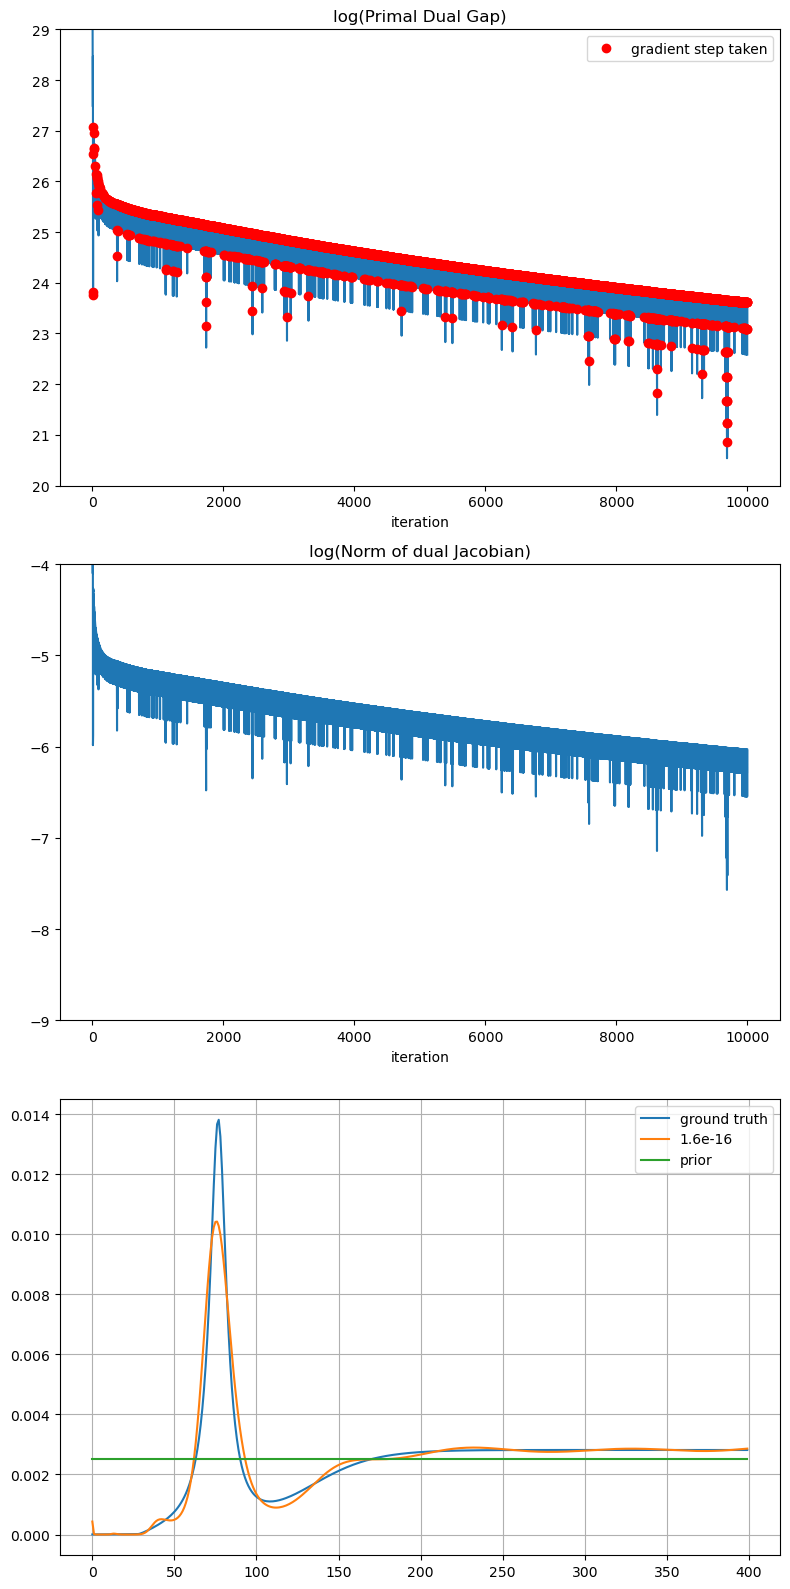

In [24]:
log_gaps = np.log(gaps)
iters = np.arange(1,10001).reshape(10000,1)
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

# Plot 1: log(Primal Dual Gap)
axs[0].plot(iters, log_gaps)
axs[0].plot(armijo_steps, [log_gaps[i] for i in armijo_steps], 'ro', label='gradient step taken')
axs[0].set_title('log(Primal Dual Gap)')
axs[0].set_xlabel('iteration')
axs[0].set_ylim(20, 29)
axs[0].legend()

# Plot 2: log(Norm of dual Jacobian)
axs[1].plot(np.log(Gnorms))
axs[1].set_title('log(Norm of dual Jacobian)')
axs[1].set_xlabel('iteration')
axs[1].set_ylim(-9, -4)

# Plot 3: Comparison plot
axs[2].plot(x0, label="ground truth")
axs[2].plot(x, label=f"{lmda}")
axs[2].plot(mu, label="prior")
axs[2].legend()
axs[2].grid()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Tests using the basic local Newton Method

Newton Sol (lambda=3e-16) RMS(x-x0): 0.00047092935506106446
Newton Sol (lambda=3e-16) RMS(Ax-b): 0.0010554123592560406
----------
Newton Sol (lambda=1e-15) RMS(x-x0): 0.0004943197220328498
Newton Sol (lambda=1e-15) RMS(Ax-b): 0.0011605674771236797
----------
Newton Sol (lambda=1e-10) RMS(x-x0): 0.0008191634890288051
Newton Sol (lambda=1e-10) RMS(Ax-b): 0.0016598232831281253
----------
Newton Sol (lambda=1e-05) RMS(x-x0): 0.001521669066519315
Newton Sol (lambda=1e-05) RMS(Ax-b): 0.022980629196860024
----------
Newton Sol (lambda=0.01) RMS(x-x0): 0.0018607672897144275
Newton Sol (lambda=0.01) RMS(Ax-b): 0.06633638326771332
----------
OLS Sol RMS(x-x0): 0.0006539727444728927
OLS Sol RMS(Ax-b): 2.168002603497676e-15


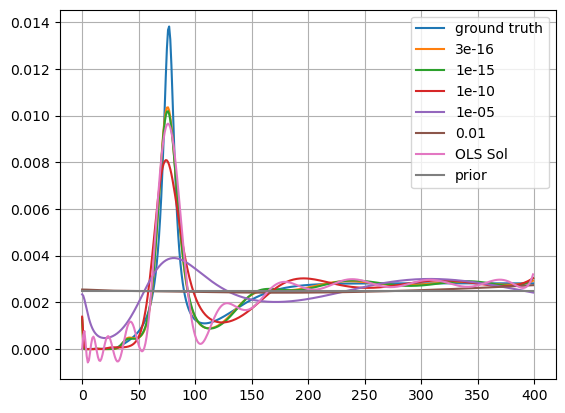

In [25]:
mu = np.ones(x0.shape[0]) / x0.shape[0] # set uniform prior mu
m, n = A.shape

#lmds = [3e-16]
lmds = [3e-16, 1e-15, 1e-10, 1e-5, 1e-2]      
# lmds = [1e-1, 1e-2, 1e-4]   
# lmds = [1e-1] 
plt.plot(x0, label="ground truth")
for lmda in lmds:
    x, y, _ = LocalNewton(A, mu, b, lmda=lmda, eps=1e-6, max_iters=100, verbose=False)
    plt.plot(x, label=f"{lmda}")
    print(f'Newton Sol (lambda={lmda}) RMS(x-x0): {np.linalg.norm(x0 - x) / np.sqrt(n)}')
    print(f'Newton Sol (lambda={lmda}) RMS(Ax-b): {np.linalg.norm(A @ x - b) / np.sqrt(m)}')
    print('-' * 10)
x_ = np.linalg.lstsq(A, b, rcond=None)
plt.plot(x_[0], label='OLS Sol')
plt.plot(mu, label="prior")
plt.legend()
plt.grid()

print(f'OLS Sol RMS(x-x0): {np.linalg.norm(x0 - x_[0]) / np.sqrt(n)}')
print(f'OLS Sol RMS(Ax-b): {np.linalg.norm(A @ x_[0] - b) / np.sqrt(m)}')